# Data Mining Cup 2019
**Fraud Detection at Self-checkout in Retail**

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.ScoreFunction import score_function

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

In [19]:
class DataTransformer:
    """
    for scaling, data transformations (new features, one-hot encoding, categorical, ...)
    """
    
    def __init__(self, scaler):
        self.scaler = scaler
        
    def apply_scaler(self, df):
        return pd.DataFrame(self.scaler.fit_transform(df.astype(np.float64)), df.index, df.columns)
    
    def inverse_scale(self, df):
        df_tmp = df.copy()
        return pd.DataFrame(self.scaler.inverse_transform(df_tmp), df_tmp.index, df_tmp.columns)
    
    def add_features(self,df):
        #TODO: Choose relevant features
        df_tmp = df.copy()
        df_tmp['totalScanned'] = df_tmp['scannedLineItemsPerSecond']*df_tmp['totalScanTimeInSeconds']
        df_tmp['avgTimePerScan'] = 1/df_tmp['scannedLineItemsPerSecond']
        df_tmp['avgValuePerScan'] = df_tmp['avgTimePerScan']*df_tmp['valuePerSecond']
        df_tmp['withoutRegisPerPosition'] = df_tmp['scansWithoutRegistration']*df_tmp['totalScanned']
        df_tmp['quantityModsPerPosition'] = df_tmp['quantityModifications']/df_tmp['totalScanned']
        return df_tmp
    
    def transform(self, df):
        """
        All in one: Apply all transform methods
            1.) addFeatures
            2.) apply_scaler
        """
        df_tmp = df.copy()
        return self.apply_scaler(self.add_features(df_tmp))

In [20]:
train_df = pd.read_csv('train.csv', sep='|')
test_df = pd.read_csv('test.csv', sep='|')

scaler = MinMaxScaler()
transformer = DataTransformer(scaler)

# Adding new Features to train and test set
train_unscaled_df = transformer.add_features(train_df)
test_unscaled_df = transformer.add_features(test_df)

train_scaled_df = transformer.apply_scaler(train_unscaled_df)
test_scaled_df  = transformer.apply_scaler(test_unscaled_df)

In [21]:
train_df['totalScanned'] = train_df['scannedLineItemsPerSecond']*train_df['totalScanTimeInSeconds']
train_df['avgTimePerScan'] = 1/train_df['scannedLineItemsPerSecond']
train_df['avgValuePerScan'] = train_df['avgTimePerScan']*train_df['valuePerSecond']
train_df['withoutRegisPerPosition'] = train_df['scansWithoutRegistration']*train_df['totalScanned']
train_df['quantityModsPerPosition'] = train_df['quantityModifications']/train_df['totalScanned']

test_df['totalScanned'] = test_df['scannedLineItemsPerSecond']*test_df['totalScanTimeInSeconds']
test_df['avgTimePerScan'] = 1/test_df['scannedLineItemsPerSecond']
test_df['avgValuePerScan'] = test_df['avgTimePerScan']*test_df['valuePerSecond']
test_df['withoutRegisPerPosition'] = test_df['scansWithoutRegistration']*test_df['totalScanned']
test_df['quantityModsPerPosition'] = test_df['quantityModifications']/test_df['totalScanned']

In [22]:
train, test = train_test_split(train_df, test_size=0.7)

X_train = train_df.drop(["fraud"],axis=1)
y_train = train_df["fraud"]
X_test = train_df.drop(["fraud"],axis=1)
y_test = train_df["fraud"]

In [23]:
print(f"X_train dimensions: {X_train.shape}")
print(f"y_train dimensions: {y_train.shape}\n")

print(f"X_test dimensions: {X_test.shape}")
print(f"y_test dimensions: {y_test.shape}\n")

X_train dimensions: (1879, 14)
y_train dimensions: (1879,)

X_test dimensions: (1879, 14)
y_test dimensions: (1879,)



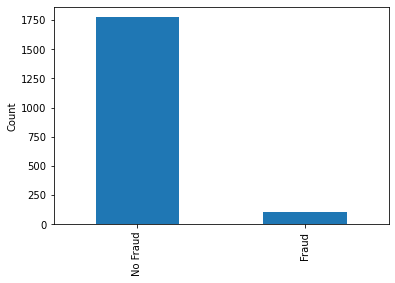

In [24]:
train_df['fraud'].value_counts().plot(kind='bar')
plt.xticks([0,1], ['No Fraud', 'Fraud'])
plt.ylabel('Count');

## Model Classifiers

In [34]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [26]:
models = {1:'Logistic Regression',
          2:'Deep Neural Network', 
          3:'Random Forest'}

### Logistic Regression

In [30]:
choice = 1

if choice == 1:
    clf = LogisticRegression(max_iter=100000)
    print('Parameters currently in use in {}:\n'.format(models[choice]))
    pprint(clf.get_params())
elif choice==2:
    clf = RandomForestClassifier(max_depth=10, n_estimators=10, max_features=2)
    print('Parameters currently in use in {}:\n'.format(models[choice]))
    pprint(clf.get_params())
elif choice==3:
    clf = Sequential()
    clf.add(Dense(128, activation='relu', kernel_initializer='random_normal', input_dim=14))
    clf.add(Dense(128, activation='relu', kernel_initializer='random_normal'))
    clf.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    print('Parameters currently in use in {}:\n'.format(models[choice]))
    print(clf.summary())

Parameters currently in use in Logistic Regression:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


#### Randomized Search Cross Validation

In [31]:
if choice == 1:
    # Create the random grid logistic regression
    random_grid_log = {'C': [float(x) for x in np.linspace(start = 0.1, stop = 1.9, num = 10)],
               'multi_class': ['multinomial'],
               'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
               'class_weight': ['balanced', None],
               'penalty': ['l2']}
elif choice==2:
    # Create the random grid Random Forest
    random_grid_rfor = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [20, 40, 60, 80, 100, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
elif choice==3:
    pass

In [32]:
pprint(random_grid_log)

{'C': [0.1,
       0.3,
       0.5,
       0.7,
       0.8999999999999999,
       1.0999999999999999,
       1.3,
       1.5,
       1.7,
       1.9],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [35]:
# Definition of the random search
random_search_log = RandomizedSearchCV(estimator=clf,
                                   param_distributions=random_grid_log,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search_log.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.8min finished


RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=100000),
                   n_iter=50,
                   param_distributions={'C': [0.1, 0.3, 0.5, 0.7,
                                              0.8999999999999999,
                                              1.0999999999999999, 1.3, 1.5, 1.7,
                                              1.9],
                                        'class_weight': ['balanced', None],
                                        'multi_class': ['multinomial'],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']},
                   random_state=8, scoring='accuracy', verbose=1)

In [36]:
print("The best hyperparameters from Random Search are:")
print(random_search_log.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search_log.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': None, 'C': 1.0999999999999999}

The mean accuracy of a model with these hyperparameters is:
0.993082837794457


#### Grid Search Cross Validation

In [37]:
# Create the parameter grid based on the results of random search 
param_grid_log = {'C': [float(x) for x in np.linspace(start = 0.3, stop = 0.7, num = 10)],
               'multi_class': ['multinomial'],
               'solver': ['sag'],
               'class_weight': ['balanced']}

param_grid_log
# Create a base model
# clf_log = LogisticRegression(random_state=8)

{'C': [0.3,
  0.34444444444444444,
  0.38888888888888884,
  0.4333333333333333,
  0.47777777777777775,
  0.5222222222222221,
  0.5666666666666667,
  0.611111111111111,
  0.6555555555555554,
  0.7],
 'multi_class': ['multinomial'],
 'solver': ['sag'],
 'class_weight': ['balanced']}

In [39]:
from sklearn.model_selection import ShuffleSplit

In [40]:
# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets_log = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search_log = GridSearchCV(estimator=clf, 
                           param_grid=param_grid_log,
                           scoring='accuracy',
                           cv=cv_sets_log,
                           verbose=1)

# Fit the grid search to the data
grid_search_log.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   54.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=LogisticRegression(max_iter=100000),
             param_grid={'C': [0.3, 0.34444444444444444, 0.38888888888888884,
                               0.4333333333333333, 0.47777777777777775,
                               0.5222222222222221, 0.5666666666666667,
                               0.611111111111111, 0.6555555555555554, 0.7],
                         'class_weight': ['balanced'],
                         'multi_class': ['multinomial'], 'solver': ['sag']},
             scoring='accuracy', verbose=1)

In [41]:
print("The best hyperparameters from Grid Search are:")
print(grid_search_log.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search_log.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.4333333333333333, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.9388083735909823


Berdasarkan hasil dari pencarian parameter terbaik dari random search dan grid search, metode random search menghasilkan rerata akurasi yang lebih baik, maka akan digunakan untuk klasifikasi.

In [43]:
best_classifier_log = random_search_log.best_estimator_

best_classifier_log

LogisticRegression(C=1.0999999999999999, max_iter=100000,
                   multi_class='multinomial', solver='newton-cg')

#### Model Fit and Performance

In [44]:
best_classifier_log.fit(X_train, y_train)

LogisticRegression(C=1.0999999999999999, max_iter=100000,
                   multi_class='multinomial', solver='newton-cg')

In [45]:
clf_pred_log = best_classifier_log.predict(X_test)

In [57]:
print("Logistic Regression Classification Report\n")
print(classification_report(y_test,clf_pred_log))

Logistic Regression Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1775
           1       0.95      0.94      0.95       104

    accuracy                           0.99      1879
   macro avg       0.97      0.97      0.97      1879
weighted avg       0.99      0.99      0.99      1879



In [58]:
tn, fp, fn, tp = confusion_matrix(y_test, clf_pred_log).ravel()
d = {
     'Model': 'Logistic Regression',
     'Accuracy': accuracy_score(y_train, best_classifier_log.predict(X_train)),
     'F1 Score': f1_score(y_test, clf_pred_log),
     'DMC Score': score_function(tp,fp,fn,tn)
}

df_models_log = pd.DataFrame(d, index=[0])
df_models_log

,Model,Accuracy,F1 Score,DMC Score
0,Logistic Regression,0.994146,0.94686,335


#### Confusion Matrix

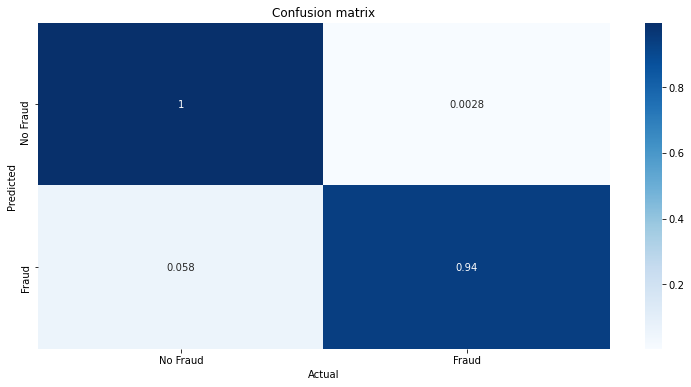

In [59]:
import seaborn as sns

conf_matrix = confusion_matrix(y_true=y_test, y_pred=clf_pred_log, normalize='true')
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=['No Fraud', 'Fraud'], 
            yticklabels=['No Fraud', 'Fraud'],
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

### Random Forest

In [60]:
choice = 2

if choice == 1:
    clf = LogisticRegression(max_iter=100000)
    print('Parameters currently in use in {}:\n'.format(models[choice]))
    pprint(clf.get_params())
elif choice==2:
    clf = RandomForestClassifier(max_depth=10, n_estimators=10, max_features=2)
    print('Parameters currently in use in {}:\n'.format(models[choice]))
    pprint(clf.get_params())
elif choice==3:
    clf = Sequential()
    clf.add(Dense(128, activation='relu', kernel_initializer='random_normal', input_dim=14))
    clf.add(Dense(128, activation='relu', kernel_initializer='random_normal'))
    clf.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    print('Parameters currently in use in {}:\n'.format(models[choice]))
    print(clf.summary())

Parameters currently in use in Deep Neural Network:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 2,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


#### Randomized Search Cross Validation

In [61]:
if choice == 1:
    # Create the random grid logistic regression
    random_grid_log = {'C': [float(x) for x in np.linspace(start = 0.1, stop = 1.9, num = 10)],
               'multi_class': ['multinomial'],
               'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
               'class_weight': ['balanced', None],
               'penalty': ['l2']}
elif choice==2:
    # Create the random grid Random Forest
    random_grid_rfor = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [20, 40, 60, 80, 100, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
elif choice==3:
    pass

In [63]:
pprint(random_grid_rfor)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [64]:
# Definition of the random search
random_search_rfor = RandomizedSearchCV(estimator=clf,
                                   param_distributions=random_grid_rfor,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search_rfor.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.5min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=10,
                                                    max_features=2,
                                                    n_estimators=10),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=8, scoring='accuracy', verbose=1)

In [65]:
print("The best hyperparameters from Random Search are:")
print(random_search_rfor.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search_rfor.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.9835007210154343


#### Grid Search Cross Validation

In [67]:
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid_rfor = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

param_grid_rfor

{'bootstrap': [False],
 'max_depth': [30, 40, 50],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [5, 10, 15],
 'n_estimators': [800]}

In [69]:
cv_sets_rfor = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search_rfor = GridSearchCV(estimator=clf, 
                           param_grid=param_grid_rfor,
                           scoring='accuracy',
                           cv=cv_sets_rfor,
                           verbose=1)

# Fit the grid search to the data
grid_search_rfor.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.6min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=RandomForestClassifier(max_depth=10, max_features=2,
                                              n_estimators=10),
             param_grid={'bootstrap': [False], 'max_depth': [30, 40, 50],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [800]},
             scoring='accuracy', verbose=1)

In [70]:
print("The best hyperparameters from Grid Search are:")
print(grid_search_rfor.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search_rfor.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800}

The mean accuracy of a model with these hyperparameters is:
0.9812130971551262


#### Model Fit and Performance

In [83]:
best_classifier_rfor = random_search_rfor.best_estimator_
best_classifier_rfor

RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt',
                       n_estimators=800)

In [84]:
best_classifier_rfor.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt',
                       n_estimators=800)

In [85]:
clf_pred_rfor = best_classifier_rfor.predict(X_test)

In [86]:
print("Logistic Regression Classification Report\n")
print(classification_report(y_test,clf_pred_rfor))

Logistic Regression Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1775
           1       1.00      1.00      1.00       104

    accuracy                           1.00      1879
   macro avg       1.00      1.00      1.00      1879
weighted avg       1.00      1.00      1.00      1879



In [87]:
tn, fp, fn, tp = confusion_matrix(y_test, clf_pred_rfor).ravel()
d = {
     'Model': 'Random Forest',
     'Accuracy': accuracy_score(y_train, best_classifier_rfor.predict(X_train)),
     'F1 Score': f1_score(y_test, clf_pred_rfor),
     'DMC Score': score_function(tp,fp,fn,tn)
}

df_models_rfor = pd.DataFrame(d, index=[0])
df_models_rfor

,Model,Accuracy,F1 Score,DMC Score
0,Random Forest,1.0,1.0,520


#### Confusion Matrix

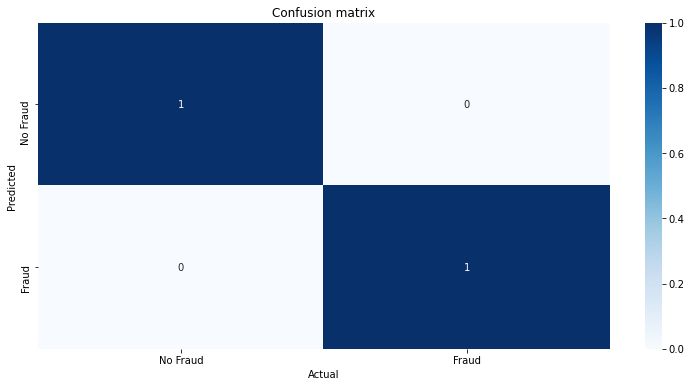

In [88]:
import seaborn as sns

conf_matrix = confusion_matrix(y_true=y_test, y_pred=clf_pred_rfor, normalize='true')
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=['No Fraud', 'Fraud'], 
            yticklabels=['No Fraud', 'Fraud'],
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

### Deep Neural Network

In [89]:
choice = 3

if choice == 1:
    clf = LogisticRegression(max_iter=100000)
    print('Parameters currently in use in {}:\n'.format(models[choice]))
    pprint(clf.get_params())
elif choice==2:
    clf = RandomForestClassifier(max_depth=10, n_estimators=10, max_features=2)
    print('Parameters currently in use in {}:\n'.format(models[choice]))
    pprint(clf.get_params())
elif choice==3:
    clf = Sequential()
    clf.add(Dense(128, activation='relu', kernel_initializer='random_normal', input_dim=14))
    clf.add(Dense(128, activation='relu', kernel_initializer='random_normal'))
    clf.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    print('Parameters currently in use in {}:\n'.format(models[choice]))
    print(clf.summary())

Parameters currently in use in Random Forest:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1920      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 18,561
Trainable params: 18,561
Non-trainable params: 0
_________________________________________________________________
None


#### Model Fit and Performance

In [91]:
clf.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
clf.fit(X_test, y_test, epochs=500, batch_size=32, verbose = False)

clf_pred_dnn = np.array(clf.predict(X_test))

In [94]:
clf_pred_dnn[clf_pred_dnn>0.5] = 1
clf_pred_dnn[clf_pred_dnn<0.5] = 0

tn, fp, fn, tp = confusion_matrix(y_test, clf_pred_dnn).ravel()

accuracy_score(y_test, clf_pred_dnn)
score_function(tp,fp,fn,tn)
f1_score(y_test, clf_pred_dnn)

print(f"Accuracy: {accuracy_score(y_test, clf_pred_dnn)}")
print(f"F1 Score: {f1_score(y_test, clf_pred_dnn)}")
print(f"DMC Score: {score_function(tp,fp,fn,tn)}")

Accuracy: 0.9925492283129325
F1 Score: 0.936936936936937
DMC Score: 170


In [95]:
tn, fp, fn, tp = confusion_matrix(y_test, clf_pred_rfor).ravel()
d = {
     'Model': 'Deep Neural Network',
     'Accuracy': accuracy_score(y_test, clf_pred_dnn),
     'F1 Score': f1_score(y_test, clf_pred_dnn),
     'DMC Score': score_function(tp,fp,fn,tn)
}

df_models_dnn = pd.DataFrame(d, index=[0])
df_models_dnn

,Model,Accuracy,F1 Score,DMC Score
0,Deep Neural Network,0.992549,0.936937,520


In [96]:
df_models_log

,Model,Accuracy,F1 Score,DMC Score
0,Logistic Regression,0.994146,0.94686,335


## Model Comparisons

In [97]:
comparisons = pd.concat([df_models_log,df_models_rfor,df_models_dnn], ignore_index=True)
comparisons

,Model,Accuracy,F1 Score,DMC Score
0,Logistic Regression,0.994146,0.946860,335
1,Random Forest,1.000000,1.000000,520
2,Deep Neural Network,0.992549,0.936937,520


In [123]:
comparisons_clf = pd.concat([df_models_log,df_models_dnn], ignore_index=True)
comparisons_clf

,Model,Accuracy,F1 Score,DMC Score
0,Logistic Regression,0.994146,0.946860,335
1,Deep Neural Network,0.992549,0.936937,520


## Predict Unlabelled Test Data

### Logistic Regression

In [99]:
pred_class_log = np.array(best_classifier_log.predict(test_df))
df_pred_log = pd.DataFrame()
df_pred_log['preds'] = [int(i) for i in pred_class_log]
df_pred_log.to_csv('results/prediction_result_logreg.csv')

### Random Forest

In [100]:
pred_class_rfor = np.array(best_classifier_rfor.predict(test_df))
df_pred_rfor = pd.DataFrame()
df_pred_rfor['preds'] = [int(i) for i in pred_class_rfor]
df_pred_rfor.to_csv('results/prediction_result_rfor.csv')

### Deep Neural Network

In [104]:
pred_class_dnn = np.array(clf.predict(test_df))
pred_class_dnn[pred_class_dnn>0.5] = 1
pred_class_dnn[pred_class_dnn<0.5] = 0

y_pred = []
for i in range(len(pred_class_dnn)):
    for j in range(len(pred_class_dnn[i])):
        temp_prediction = abs(pred_class_dnn[i][j])
        y_pred.append(temp_prediction)

df_pred_dnn = pd.DataFrame()
df_pred_dnn['preds'] = [int(i) for i in y_pred]

df_pred_dnn.to_csv('results/prediction_result_dnn.csv')

## Evaluation on Test Data Prediction

In [105]:
solution = pd.read_csv('solution.csv', sep='|')

### Logistic Regression

In [116]:
print(f'Accuracy: {accuracy_score(solution, df_pred_log)}')
print(f'F1: {f1_score(solution, df_pred_log)}')

Accuracy: 0.9909760881392272
F1: 0.9049984148790025


### Random Forest

In [117]:
print(f'Accuracy: {accuracy_score(solution, df_pred_rfor)}')
print(f'F1: {f1_score(solution, df_pred_rfor)}')

Accuracy: 0.9802899295552687
F1: 0.7700594875638203


### Deep Neural Network

In [118]:
print(f'Accuracy: {accuracy_score(solution, df_pred_dnn)}')
print(f'F1: {f1_score(solution, df_pred_dnn)}')

Accuracy: 0.9797318322255034
F1: 0.8117611962561062


In [119]:
xcvzx = pd.read_csv('train.csv', sep='|')
xcvzx.columns

Index(['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications',
       'scannedLineItemsPerSecond', 'valuePerSecond',
       'lineItemVoidsPerPosition', 'fraud'],
      dtype='object')

In [122]:
len(xcvzx.columns)

10

In [120]:
train_df.columns

Index(['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications',
       'scannedLineItemsPerSecond', 'valuePerSecond',
       'lineItemVoidsPerPosition', 'fraud', 'totalScanned', 'avgTimePerScan',
       'avgValuePerScan', 'withoutRegisPerPosition',
       'quantityModsPerPosition'],
      dtype='object')

In [121]:
len(train_df.columns)

15